# Results - Anomaly Detection with Real-world Data
In this notebook, we visualize the results of the anomaly detection algorithms trained on snythetic data and tested on real-world data.
Notice that you have to have results from the notebook `mixed_anomaly_AB.ipynb` to successfully execute this notebook!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/mixed_anomaly_results.ipynb)

## Prerequisites

In [1]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets


# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [2]:
from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_metrics_bar,
    get_metrics_summary,
    plot_cv_indices)

# configure fonts, etc...
init_plotting()

from scoring_utils import (
    get_synth_regression_scoring,
    SHM_Scoring)

from bench_utils import extract_metrics

## Data Loading

In [3]:
result_file = "mixed_anomaly_AB.pkl"
result_file = Path(RESULT_PATH, result_file)

results = pd.read_pickle(result_file)

In [4]:
results.head()

,fit_time,score_time,test_balanced_accuracy,test_roc_auc,test_f1_pos,test_f1_neg,test_recall_pos,test_recall_neg,test_precision_pos,test_precision_neg,test_roc_auc_ovr,test_tn,test_fp,test_fn,test_tp,model
0,1.064154,0.064826,0.840278,0.925926,0.206897,0.809917,1.0,0.680556,0.115385,1.0,0.840278,147,69,0,9,IsolationForest
1,1.085098,0.063858,0.831019,0.961420,0.197802,0.796657,1.0,0.662037,0.109756,1.0,0.831019,143,73,0,9,IsolationForest
2,1.076123,0.065853,0.847222,0.989712,0.214286,0.819672,1.0,0.694444,0.120000,1.0,0.847222,150,66,0,9,IsolationForest
3,1.099033,0.062831,0.833333,0.965535,0.200000,0.800000,1.0,0.666667,0.111111,1.0,0.833333,144,72,0,9,IsolationForest
4,1.106019,0.063829,0.842593,0.958333,0.209302,0.813187,1.0,0.685185,0.116883,1.0,0.842593,148,68,0,9,IsolationForest


## Plot BACC and ROC AUC

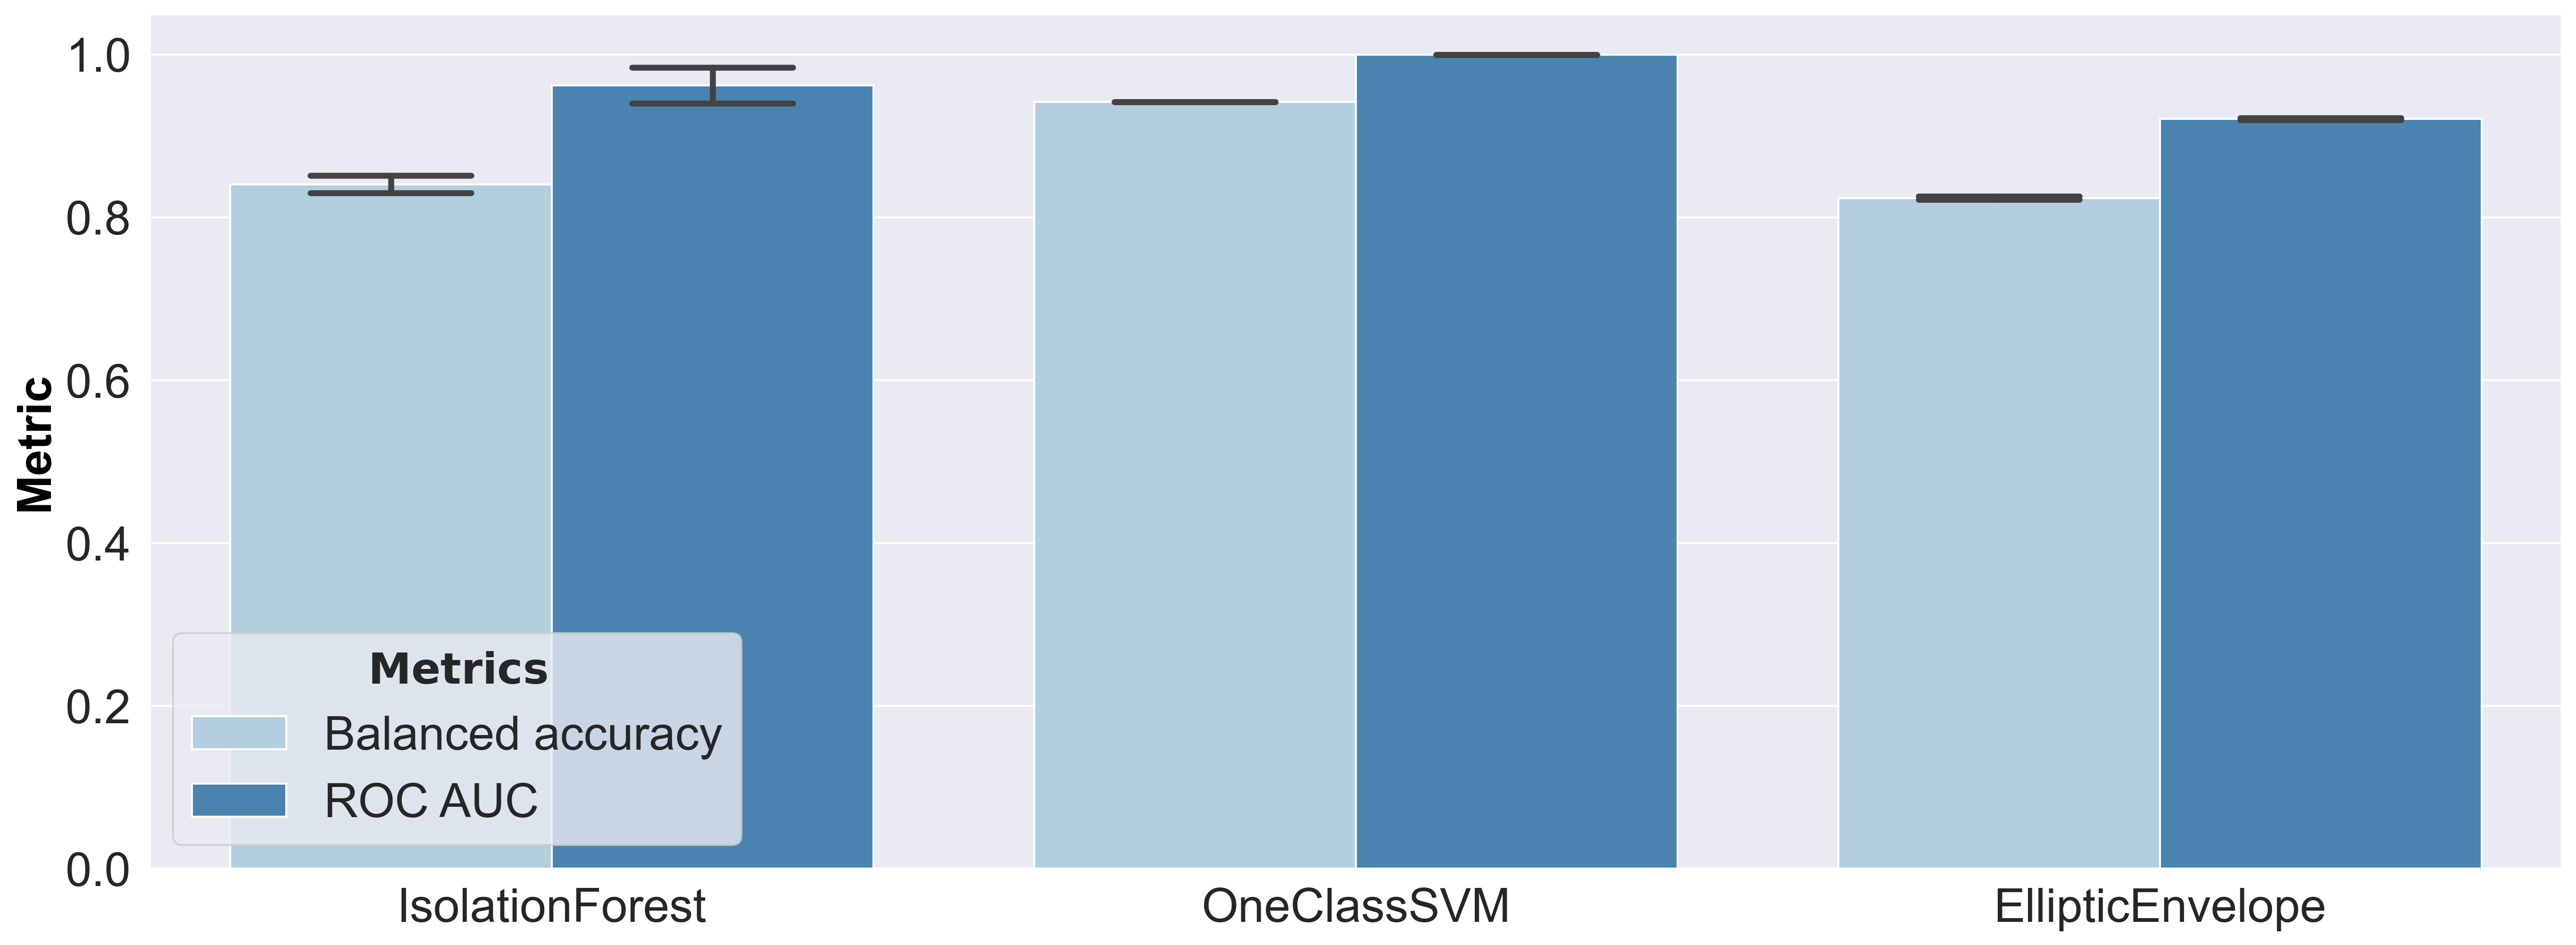

In [5]:
axis_font = {#'family': 'Times',
        'color':  'black',
        'weight': 'bold',
        'size': 24,
        }
df = extract_metrics(results, ['test_balanced_accuracy', 'test_roc_auc'])

fig = plot_metrics_bar(df)

plt.ylabel('Metric', fontdict=axis_font)
plt.xlabel('')

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [item.replace('test_balanced_accuracy',
                           'Balanced accuracy').replace('test_roc_auc',
                                                        'ROC AUC')
              for item in labels]
plt.legend(handles, new_labels, ncol=1, loc='best',
           title="$\\bf{Metrics}$",
           title_fontsize=22)

fname = Path(RESULT_PATH, r"mixed_anomaly_bacc.pdf")
plt.savefig(fname, bbox_inches='tight')
plt.show()

In [6]:
get_metrics_summary(df)

mean       std
model            metrics                                   
EllipticEnvelope test_balanced_accuracy  0.823893  0.002046
                 test_roc_auc            0.921043  0.001375
IsolationForest  test_balanced_accuracy  0.840676  0.010666
                 test_roc_auc            0.962268  0.022053
OneClassSVM      test_balanced_accuracy  0.942130  0.000000
                 test_roc_auc            1.000000  0.000000

## Plot False Positives and True Negatives

In [7]:
df = extract_metrics(results, ['test_fp', 'test_tn'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 4224 to 4991
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   model    768 non-null    object 
 1   metrics  768 non-null    object 
 2   values   768 non-null    float64
dtypes: float64(1), object(2)
memory usage: 24.0+ KB


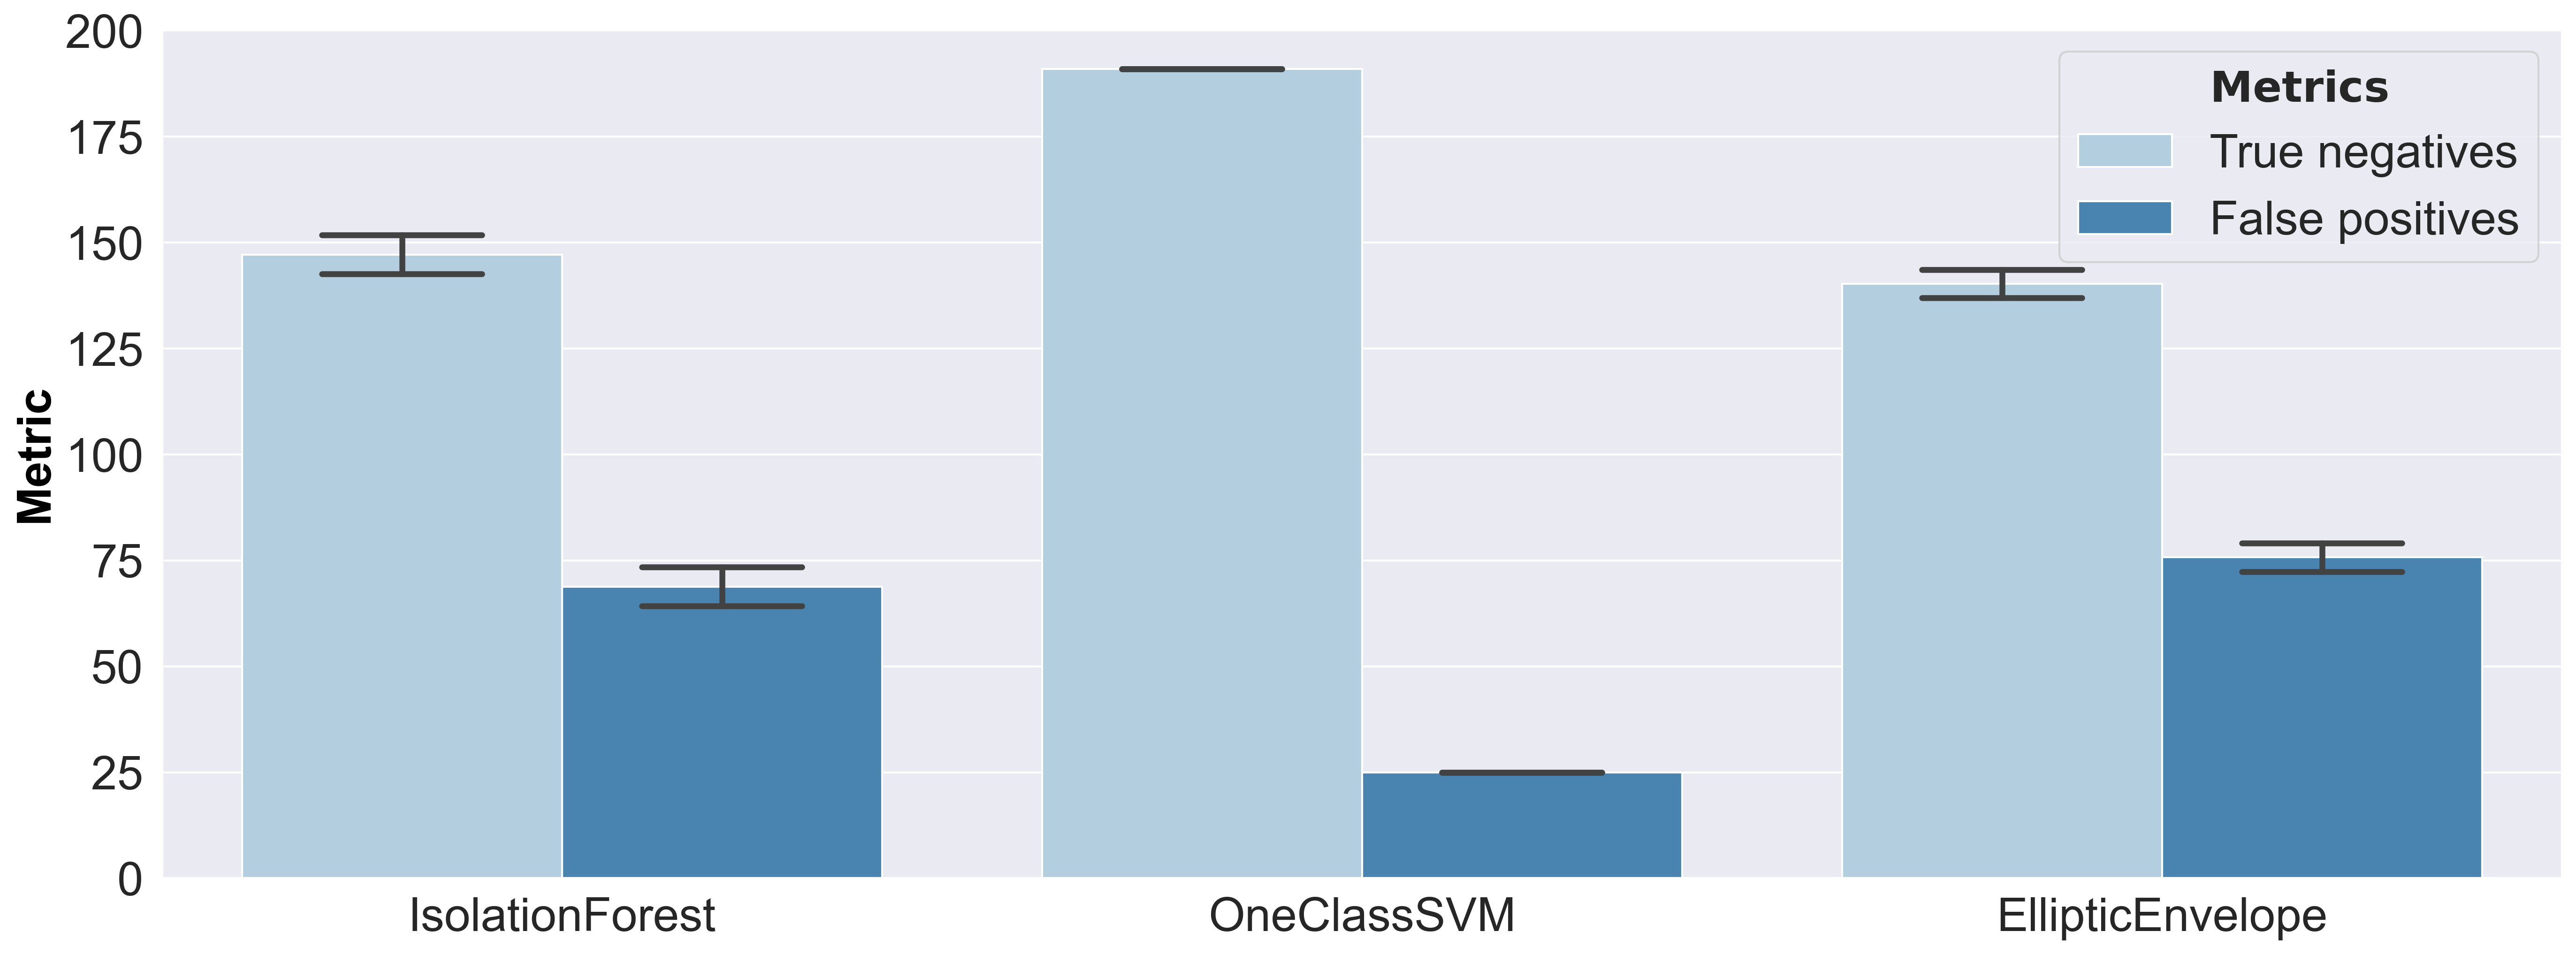

In [8]:
fig = plot_metrics_bar(extract_metrics(results, ['test_fp', 'test_tn']))

plt.ylabel('Metric', fontdict=axis_font)
plt.xlabel('')
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [item.replace('test_tn',
                           'True negatives').replace('test_fp',
                                                        'False positives')
              for item in labels]

plt.legend(handles, new_labels, ncol=1, loc='best',
           title="$\\bf{Metrics}$",
           title_fontsize=22);

In [9]:
get_metrics_summary(df)

mean       std
model            metrics                      
EllipticEnvelope test_fp   75.703125  3.358757
                 test_tn  140.296875  3.358757
IsolationForest  test_fp   68.828125  4.607610
                 test_tn  147.171875  4.607610
OneClassSVM      test_fp   25.000000  0.000000
                 test_tn  191.000000  0.000000

## Plot False Positive Rates and True Negative Rates

In [10]:
# count anomalies for normalization
#! only works with ['test_fp', 'test_tn']
n_anomalies = 0
for d in df.groupby('metrics'):
    print(d[1].values[0][-1])
    n_anomalies += int(d[1].values[0][-1])

69.0
147.0


In [11]:
# scale to yield rates
df['values'] = df['values']/n_anomalies

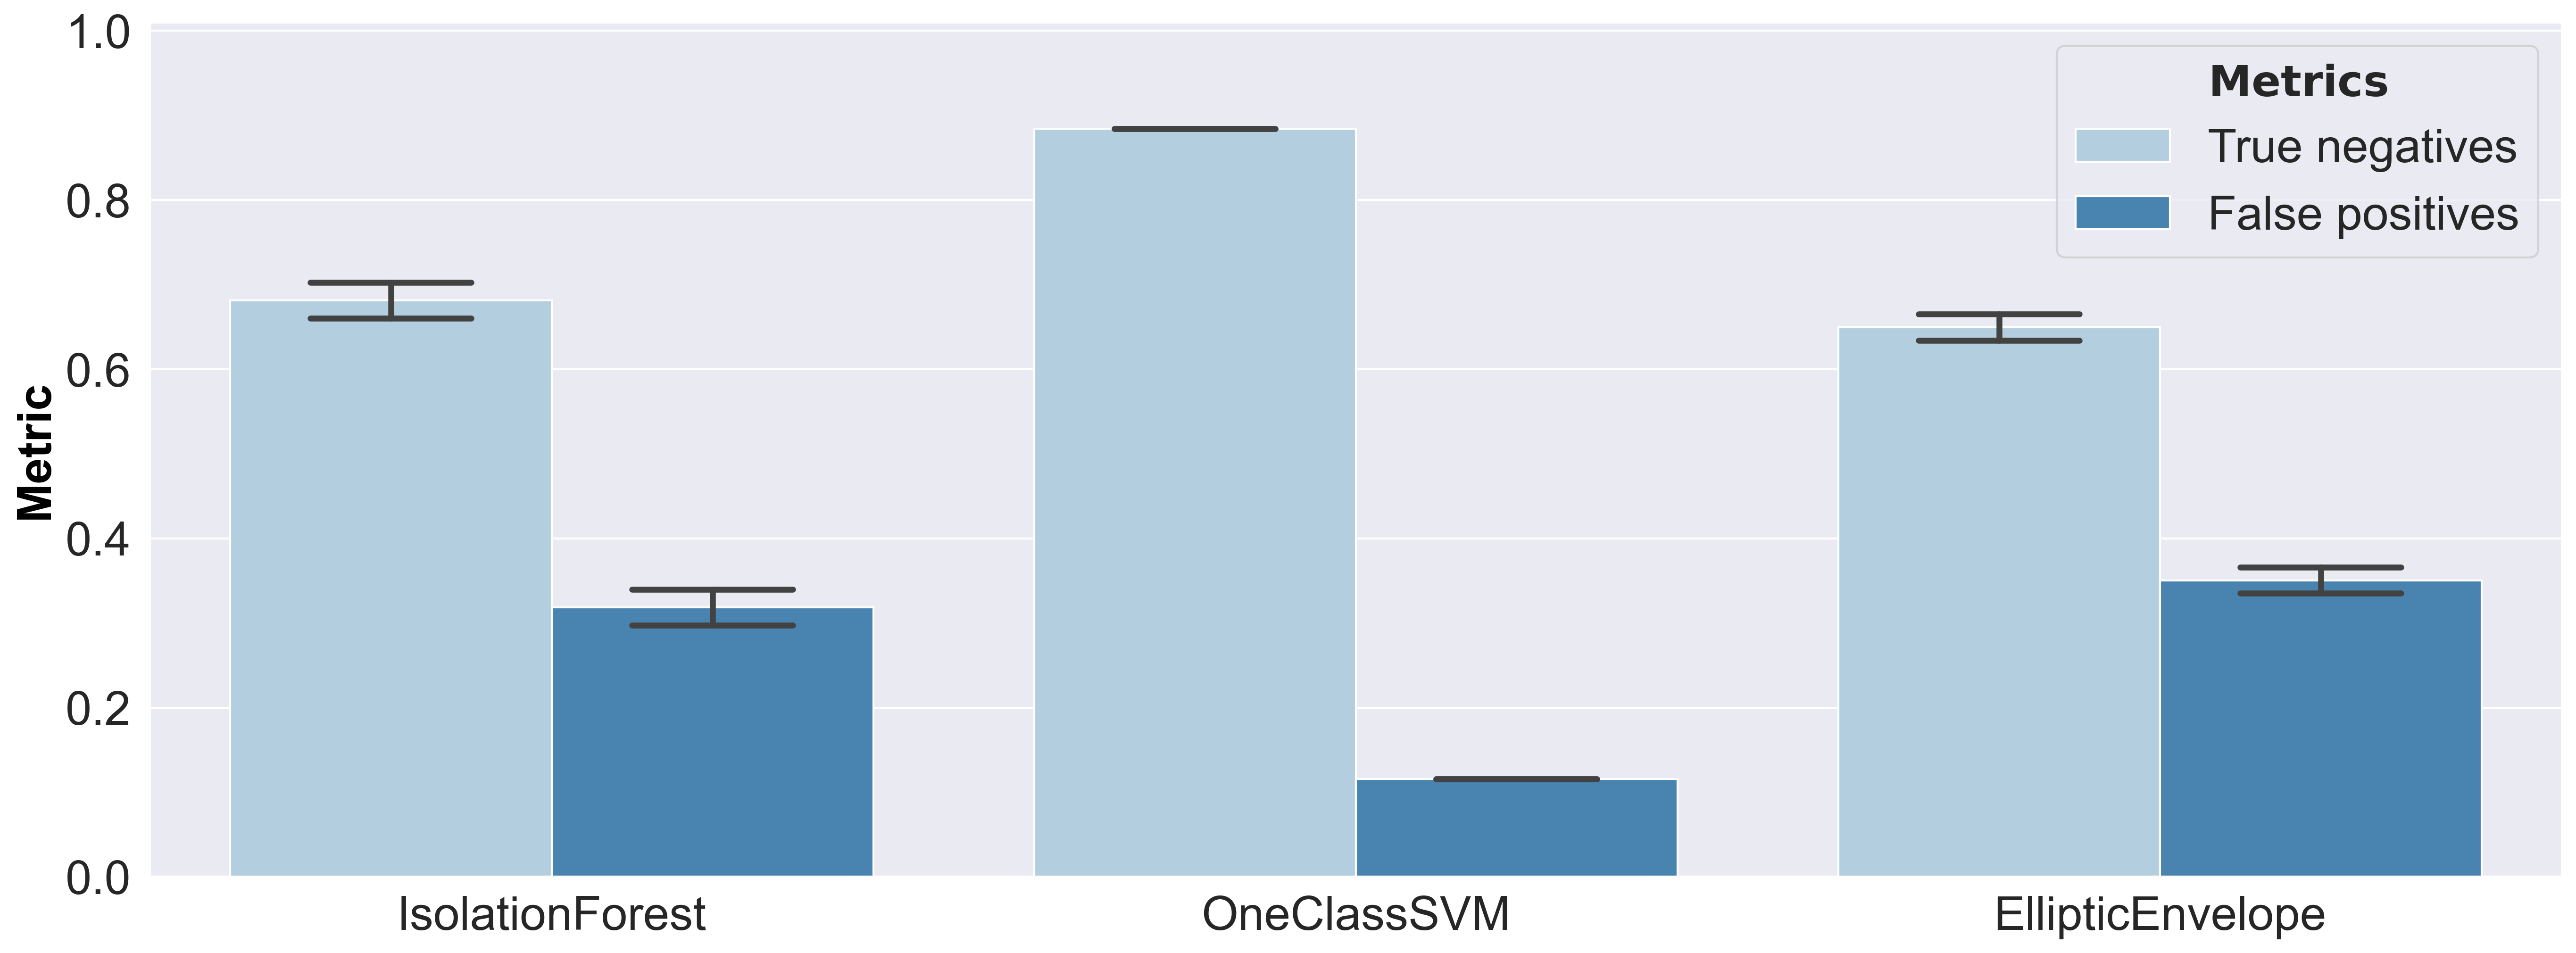

In [12]:
fig = plot_metrics_bar(df)

plt.ylim([None, 1.01])
plt.ylabel('Metric', fontdict=axis_font)
plt.xlabel('')
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [item.replace('test_tn',
                           'True negatives').replace('test_fp',
                                                        'False positives')
              for item in labels]
plt.legend(handles, new_labels, ncol=1, loc='best',
           title="$\\bf{Metrics}$",
           title_fontsize=22)

fname = Path(RESULT_PATH, r"mixed_anomaly_fp.tn.png")
plt.savefig(fname, bbox_inches='tight')
plt.show()

In [13]:
get_metrics_summary(df)

mean           std
model            metrics                        
EllipticEnvelope test_fp  0.350477  1.554980e-02
                 test_tn  0.649523  1.554980e-02
IsolationForest  test_fp  0.318649  2.133153e-02
                 test_tn  0.681351  2.133153e-02
OneClassSVM      test_fp  0.115741  2.786464e-17
                 test_tn  0.884259  1.114585e-16